In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import pandas as pd
from InverseFuncs import trajectory, getLoss, reset_theta, theta_range

from DDPGv2Agent import Agent
from FireflyEnv import Model # firefly_task.py
from collections import deque
from Inverse_Config import Inverse_Config
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# read configuration parameters
arg = Inverse_Config()

# fix random seed
import random
random.seed(arg.SEED_NUMBER)
import torch
torch.manual_seed(arg.SEED_NUMBER)
if torch.cuda.is_available():
    torch.cuda.manual_seed(arg.SEED_NUMBER)
import numpy as np
np.random.seed(arg.SEED_NUMBER)
import time

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = multiprocessing.cpu_count()
print("{} cores are available".format(num_cores))

# if gpu is to be used
#CUDA = False
#device = "cpu"

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tic = time.time()



filename = '20191231-172726-01081157' # agent information

learning_arg = torch.load('../firefly-inverse-data/data/20191231-172726_arg.pkl')

DISCOUNT_FACTOR = learning_arg.DISCOUNT_FACTOR
arg.gains_range = learning_arg.gains_range
arg.std_range = learning_arg.std_range
arg.goal_radius_range = learning_arg.goal_radius_range
arg.WORLD_SIZE = learning_arg.WORLD_SIZE
arg.DELTA_T = learning_arg.DELTA_T
arg.EPISODE_TIME = learning_arg.EPISODE_TIME
arg.EPISODE_LEN = learning_arg.EPISODE_LEN
arg.PI_STD = 0.1
arg.NUM_EP = 500



env = Model(arg) # build an environment
env.max_goal_radius = arg.goal_radius_range[1] # use the largest world size for goal radius
env.box = arg.WORLD_SIZE
agent = Agent(env.state_dim, env.action_dim, arg,  filename, hidden_dim=128, gamma=DISCOUNT_FACTOR, tau=0.001) #, device = "cpu")
agent.load(filename)


12 cores are available
Running DDPG Agent: using  cpu


In [2]:
arg.PI_STD

0.1

In [3]:
arg.NUM_EP

500

In [4]:
arg.NUM_SAMPLES

5

In [5]:
def loss_cal(vel, obs_gains_vel, gain_space, true_theta):
    
    loss_log = torch.zeros(len(gain_space)+1)
    pro_gains = torch.zeros(2)
    pro_noise_stds = torch.zeros(2)
    obs_gains = torch.zeros(2)
    obs_noise_stds = torch.zeros(2)
    goal_radius = torch.zeros(1)
    
    theta_log = []
    inputs_ang = np.sort(np.append(gain_space, true_theta[5]))

    obs_gains[0] = obs_gains_vel
    for ang, obs_gains_ang in enumerate(tqdm(inputs_ang)):
        obs_gains[1] = obs_gains_ang
        for pro_gains_vel  in [true_theta[0]]:#np.append(gain_space, true_theta[4]):
            pro_gains[0] = pro_gains_vel
            for pro_gains_ang in [true_theta[1]]:#np.append(gain_space, true_theta[5]):
                pro_gains[1] = pro_gains_ang
                for pro_std_vel in [true_theta[2]]:#np.append(std_space, true_theta[2]):
                    pro_noise_stds[0] = pro_std_vel
                    for pro_std_ang in [true_theta[3]]:#np.append(std_space, true_theta[3]):
                        pro_noise_stds[1] = pro_std_ang
                        for obs_std_vel in [true_theta[6]]:#np.append(std_space, true_theta[6]):
                            obs_noise_stds[0] = obs_std_vel 
                            for obs_std_ang in [true_theta[7]]:#np.append(std_space, true_theta[7]):
                                obs_noise_stds[1] = obs_std_ang
                                for goal_r in [true_theta[8]]: #np.append(goal_radius_space, true_theta[8]):
                                    goal_radius[0] = goal_r
                                    
                                    
                                    theta = torch.cat([pro_gains, pro_noise_stds, obs_gains, obs_noise_stds, goal_radius])
    
    
                                    theta_log.append(theta.data)
                                    loss = getLoss(agent, x_traj, a_traj, theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)
                                    loss_log[ang] = loss.data
                                    #loss_log.append(loss.data)

                                    print("num:{}, theta:{}, loss:{}".format(vel, theta, loss))
                        
                        
    """
    result = {'true_theta': true_theta,
         'true_loss': true_loss,
         'theta_log': theta_log,
         'loss_log': loss_log}
    """
    return loss_log


In [6]:
# true theta
true_theta = reset_theta(arg.gains_range, arg.std_range, arg.goal_radius_range)
#true_theta[4]=8.5
#true_theta[5]=10.5

x_traj, obs_traj, a_traj, _ = trajectory(agent, true_theta, env, arg, arg.gains_range, arg.std_range,arg.goal_radius_range, arg.NUM_EP)  # generate true trajectory
true_loss = getLoss(agent, x_traj, a_traj, true_theta, env, arg.gains_range, arg.std_range, arg.PI_STD, arg.NUM_SAMPLES)  # this is the lower bound of loss?
print("true loss:{}".format(true_loss))
print("true_theta:{}".format(true_theta))



true loss:47879.9609375
true_theta:tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])


In [7]:
gain_space = np.linspace(arg.gains_range[0],arg.gains_range[1], num = 9)
std_space = np.linspace(arg.std_range[0], arg.std_range[1], num = 3)
goal_radius_space = np.linspace(arg.goal_radius_range[0], arg.goal_radius_range[1], num =3)

In [8]:
gain_space

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ])

In [9]:
true_theta


tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [10]:
inputs_vel = np.sort(np.append(gain_space, true_theta[4]))
inputs_ang = np.sort(np.append(gain_space, true_theta[5]))
#loss_log = torch.zeros([len(gain_space)+1, len(gain_space)+1])
loss_log = Parallel(n_jobs=num_cores)(delayed(loss_cal)(vel, obs_gains_vel, gain_space, true_theta) for vel, obs_gains_vel in enumerate(inputs_vel))

"""
for vel, pro_gains_vel in enumerate(inputs): 
    result_log = loss_cal(vel, pro_gains_vel, gain_space, true_theta) 
"""


'\nfor vel, pro_gains_vel in enumerate(inputs): \n    result_log = loss_cal(vel, pro_gains_vel, gain_space, true_theta) \n'

In [11]:
loss_log
    

[tensor([52028.9531, 52703.2227, 52073.6250, 50875.3633, 49326.3203, 49819.1758,
         48587.0664, 47184.9141, 46193.7578, 49343.9883]),
 tensor([50793.4180, 50146.2930, 51599.1016, 46675.5625, 49042.9023, 44384.9492,
         46781.6406, 47421.5195, 48600.4492, 48474.6133]),
 tensor([51348.0820, 50864.3320, 49682.0234, 49733.5859, 48111.5156, 46887.9922,
         47222.6758, 46424.6523, 46858.9180, 52897.1680]),
 tensor([49151.8906, 50225.7422, 47988.3320, 46962.3750, 45168.7344, 47962.5898,
         46193.3516, 47560.1953, 49764.4492, 52816.8281]),
 tensor([49089.2422, 48928.3789, 47662.3984, 46271.1055, 46768.0352, 47500.1680,
         49639.8555, 51331.6836, 54329.6992, 55552.4141]),
 tensor([45541.1367, 45079.7070, 47054.2891, 44195.9453, 46765.8047, 48107.3125,
         49724.3125, 51853.2656, 53870.2031, 55605.8438]),
 tensor([44520.2891, 44577.8047, 46383.4648, 46549.4062, 47557.6680, 50421.7617,
         53240.4609, 52587.2734, 56362.5430, 57750.7852]),
 tensor([44693.3555,

In [12]:
loss_log_tot = torch.cat([loss_log[i] for i in range (len(loss_log))])

In [13]:
loss_log_tot

tensor([52028.9531, 52703.2227, 52073.6250, 50875.3633, 49326.3203, 49819.1758,
        48587.0664, 47184.9141, 46193.7578, 49343.9883, 50793.4180, 50146.2930,
        51599.1016, 46675.5625, 49042.9023, 44384.9492, 46781.6406, 47421.5195,
        48600.4492, 48474.6133, 51348.0820, 50864.3320, 49682.0234, 49733.5859,
        48111.5156, 46887.9922, 47222.6758, 46424.6523, 46858.9180, 52897.1680,
        49151.8906, 50225.7422, 47988.3320, 46962.3750, 45168.7344, 47962.5898,
        46193.3516, 47560.1953, 49764.4492, 52816.8281, 49089.2422, 48928.3789,
        47662.3984, 46271.1055, 46768.0352, 47500.1680, 49639.8555, 51331.6836,
        54329.6992, 55552.4141, 45541.1367, 45079.7070, 47054.2891, 44195.9453,
        46765.8047, 48107.3125, 49724.3125, 51853.2656, 53870.2031, 55605.8438,
        44520.2891, 44577.8047, 46383.4648, 46549.4062, 47557.6680, 50421.7617,
        53240.4609, 52587.2734, 56362.5430, 57750.7852, 44693.3555, 43817.4453,
        45855.2109, 51514.6797, 48138.71

In [14]:
true_theta

tensor([11.4042,  8.6168,  0.2885,  0.9043, 11.1173,  8.1504,  1.7711,  0.1619,
         0.2809])

In [15]:
dx, dy = 0.25, 0.25
new_gain_space = np.append(gain_space, gain_space.max()+0.5)

pinputs_vel = np.sort(np.append(new_gain_space, true_theta[4]))
pinputs_ang = np.sort(np.append(new_gain_space, true_theta[5]))
y, x = np.meshgrid(pinputs_vel-dx, pinputs_ang-dy)

In [16]:
new_gain_space

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5])

Text(0.5, 1.0, 'true[forw,ang]:tensor([11.1173,  8.1504])')

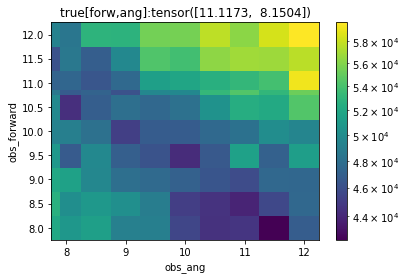

In [17]:
Z = loss_log_tot
plt.pcolor(x, y, Z.view(len(inputs_vel), len(inputs_ang)), norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.colorbar()
plt.xlabel('obs_ang')
plt.ylabel('obs_forward')
plt.title('true[forw,ang]:{}'.format(true_theta[4:6].data))

In [18]:
torch.save(loss_log, '../firefly-inverse-data/data/'+filename+'loss_obs_plotter.pkl')